In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [33]:
# Load vmem simulation data
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [34]:
# Load simulation data with full morphologies
base_dir_plot_morph = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/imem_plot_data'

# Imem plot data for selected frequencies contains morphology information for plotting
morph_plot_file_paths = [
    os.path.join(base_dir_plot_morph, f'plot_imem_{i}.npy')
    for i in range(8)
]

In [35]:
pc_cells = []
inhb_cells = []
ss_cells = []
i = 0
for cell_name in vmem_amp_data.keys():
    if 'PC' in cell_name or 'SP' in cell_name:
        pc_cells.append(cell_name)
    elif 'SS' in cell_name:
        ss_cells.append(cell_name)
    else:
        inhb_cells.append(cell_name)
    i += 1
print('tot = ', i)
print('pc = ', len(pc_cells))
print('ss = ', len(ss_cells))
print('inhb = ', len(inhb_cells))
print('sum = ', len(pc_cells) + len(inhb_cells) +len(ss_cells) )

tot =  1023
pc =  58
ss =  5
inhb =  960
sum =  1023


In [36]:
# Can only load some selected cells at a time for plotting
def load_plot_data_from_files(plot_file_paths, selected_cells):
    """Loads data for the selected cells from multiple .npy files. Ensures effective loading without using too much RAM"""
    data = {}
    
    for file_path in plot_file_paths:
        temp_data = np.load(file_path, allow_pickle=True).item()  # Load the .npy dictionary
        
        for cell in selected_cells:
            if cell in temp_data:
                data[cell] = temp_data[cell]  # Store only required cell data

        # Stop early if all selected cells have been found
        if len(data) == len(selected_cells):
            break  

    return data

In [37]:
selected_cells = ['L4_BP_bIR215_5', "L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3", "L5_NGC_bNAC219_5", 'L4_SS_cADpyr230_1']

cell_names = {
    'L4_BP_bIR215_5': 'L4 Bipolar cell (BP)',
    "L5_MC_bAC217_1": "L5 Martinotti cell (MC)",
    "L5_TTPC2_cADpyr232_3": "L5 Pyramidal cell (TTPC)",
    "L5_NGC_bNAC219_5": "L5 Neurogliaform cell (NGC)",
    'L4_SS_cADpyr230_1': 'L4 Spiny Stellate cell (SS)'
}

short_cell_names = {
    'L4_BP_bIR215_5': 'L4 BP',
    "L5_MC_bAC217_1": "L5 MC",
    "L5_TTPC2_cADpyr232_3": "L5 TTPC",
    "L5_NGC_bNAC219_5": "L5 NGC",
    'L4_SS_cADpyr230_1': 'L4 SS'
}

cell_vmem_colors = {
    'L4_BP_bIR215_5': "tab:grey",
    "L5_MC_bAC217_1": "tab:cyan",
    "L5_TTPC2_cADpyr232_3": "tab:olive",
    "L5_NGC_bNAC219_5": 'tab:brown',
    'L4_SS_cADpyr230_1': 'tab:pink'
}


In [38]:
def plot_morph_and_amp(morph_plot_file_paths, amp_data, amp_type, selected_cells):
    """Plot morphology examples (A) and amplitude spectra (B). Can be either cdm amplitudes or vmem amplitudes. Vmem amplitudes used in Fig1."""
    
    morph_dict = load_plot_data_from_files(morph_plot_file_paths, selected_cells)

    unique_cells = list(morph_dict.keys())
    if selected_cells:
        unique_cells = [cell for cell in unique_cells if cell in selected_cells]

    num_cells = len(unique_cells)
    assert num_cells == 4, "This function expects exactly 4 selected cells for subplot A."

    # --- Figure layout: 2 rows, 4 columns ---
    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(
        2, 4,
        width_ratios=[0.3, 0.3, 0.3, 4],
        height_ratios=[1.6, 0.4],
        wspace=0.8, hspace=0.25
    )

    gs_morph = gs[:, :3].subgridspec(
        2, 3,
        wspace=0.15,   # << reduce spacing *only* between morphology axes
        hspace=0.05
    )

    # --- Morphology subplots (same layout as original) ---
    axs_morph = []
    ax0 = fig.add_subplot(gs_morph[:, 0])      # L4 BP
    ax1 = fig.add_subplot(gs_morph[0, 1])      # L5 MC
    ax2 = fig.add_subplot(gs_morph[:, 2])      # L5 TTPC
    ax3 = fig.add_subplot(gs_morph[1, 1])      # L5 NGC
    axs_morph.extend([ax0, ax1, ax2, ax3])

    all_x, all_z = [], []

    # --- Plot morphologies ---
    for i, label in enumerate(unique_cells):
        # Estimate figure height in data units for conversion:
        ax1 = axs_morph[1]  # L5 MC axis
        ax2 = axs_morph[2]  # L5 TTPC axis
        ax3 = axs_morph[3]  # L5 NGC axis
        fig.canvas.draw()  # Ensure layout positions are initialized

        z_range = np.ptp(all_z) if len(all_z) > 0 else 1000  # fallback

        # Move MC downward
        move_fraction_mc = 1 / z_range
        pos_mc = ax1.get_position()
        new_pos_mc = [pos_mc.x0, pos_mc.y0 - move_fraction_mc, pos_mc.width, pos_mc.height]
        ax1.set_position(new_pos_mc)

        # Move TTPC downward
        move_fraction_ttpc = 7 / z_range  
        pos_ttpc = ax2.get_position()
        new_pos_ttpc = [pos_ttpc.x0, pos_ttpc.y0 - move_fraction_ttpc, pos_ttpc.width, pos_ttpc.height]
        ax2.set_position(new_pos_ttpc)

        # Move NGC upward
        move_fraction_ngc = 40 / z_range
        pos_ngc = ax3.get_position()
        new_pos_ngc = [pos_ngc.x0, pos_ngc.y0 + move_fraction_ngc, pos_ngc.width, pos_ngc.height]
        ax3.set_position(new_pos_ngc)

        
        ax = axs_morph[i]
        cell_data = morph_dict[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        color = cell_vmem_colors[label]

        # Draw morphology
        for idx in range(totnsegs):
            ax.plot(x[idx], z[idx], c=color, lw=1)

        # Soma marker
        ax.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0],
                'o', color='black', markersize=3, label = 'Soma')

        # Collect extents for scale bar placement
        all_x.extend(x.flatten())
        all_z.extend(z.flatten())

        # Clean style: no axes or frame
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.set_aspect('equal', adjustable='box')

        # Add cell title
        ax.set_title(f'{short_cell_names[label]}', fontsize=7)
    
    # --- Ensure shared x-axis limits across morphology plots ---
    all_x = np.array(all_x)

    # Determine common axis limits
    x_min, x_max = np.min(all_x), np.max(all_x)

    # Apply same limits to all morphology subplots
    for ax in axs_morph:
        ax.set_xlim(x_min, x_max)

    # --- Shared scale bar ---
    scale_bar_length = 100  # µm  
    ax_xlim = ax0.get_xlim()
    ax_ylim = ax0.get_ylim()
    # Determine scale bar x-position 
    scale_bar_x_start = ax_xlim[0] + 0.10 * (ax_xlim[1] - ax_xlim[0])
    scale_bar_x_end = scale_bar_x_start + scale_bar_length
    
    # Determine scale bar y-position 
    if len(all_z) > 0:
        scale_bar_y = np.min(all_z) - 0.05 * np.ptp(all_z)
    else:
        # Fallback if no data was collected, or use a fixed offset from the bottom limit
        scale_bar_y = ax_ylim[0] - 200 
    
    # Put scale bar on bottom-left subplot (L4 BP) -> ax0
    ax0.plot([scale_bar_x_start, scale_bar_x_end],
             [scale_bar_y, scale_bar_y], color='k', lw=1)
    ax0.text((scale_bar_x_start + scale_bar_x_end) / 2, 
             scale_bar_y - 40, # 40 µm offset below the bar
             f'{scale_bar_length} µm', fontsize=9,
             va='top', ha='center')
    
    # Create a single legend for Soma, placed at the bottom-left of the figure
    dot_handle = plt.Line2D([], [], color='black', marker='o', linestyle='None', markersize=3, label='Soma')
    fig.legend(handles=[dot_handle],
            loc='center',  # ignored when bbox_to_anchor is used
            bbox_to_anchor=(0.1, 0.1),  # (x, y) in figure coordinates
            fontsize=7, frameon=True)

    # Ensure all morphology plots can contain the scale bar if placed far below.
    current_ymin, current_ymax = ax0.get_ylim()
    if scale_bar_y - 10 < current_ymin:
        ax0.set_ylim(scale_bar_y - 10, current_ymax)

    # --- Add subplot label A ---
    ax0.text(-0.35, 1.2, 'A', transform=ax0.transAxes,
             fontsize=10, fontweight='bold')

    # --- Subplot B: amplitude spectra ---
    axB = fig.add_subplot(gs[:, 3])

    for cell_name, data in amp_data.items():
        if cell_name in selected_cells:
            if amp_type == 'soma_amp':
                frequencies = data['freq']
                ylab = 'Soma $V_\mathrm{m}$ Amplitude [mV]'
                color = cell_vmem_colors[cell_name]
            elif amp_type == 'cdm':
                frequencies = data['frequency']
                ylab = "Dipole Moment Amplitude [A·m]"
                color = cell_cdm_colors[cell_name]

            amplitudes = data[amp_type]
            axB.loglog(frequencies, amplitudes,
                       label=f'{short_cell_names[cell_name]}', color=color)

    axB.set_xlabel('Frequency [Hz]')
    axB.set_ylabel(ylab)
    axB.set_xlim(left=frequencies[0], right=frequencies[-1])
    axB.grid(linestyle='--', linewidth=0.5)
    axB.legend(loc='upper right', ncol=1, fontsize=7, frameon=False)
    axB.text(-0.1, 1.1, 'B', transform=axB.transAxes,
             fontsize=10, fontweight='bold')

    # Equal aspect for amplitude plot
    axB.set_aspect('equal', adjustable='box')
    
    plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/neocortical/fig1.pdf')
    plt.show()


<>:151: SyntaxWarning: invalid escape sequence '\m'
<>:151: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_40419/2396254511.py:151: SyntaxWarning: invalid escape sequence '\m'
  ylab = 'Soma $V_\mathrm{m}$ Amplitude [mV]'


In [39]:
plot_morph_and_amp(morph_plot_file_paths, vmem_amp_data, 'soma_amp', selected_cells)

/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_40419/2396254511.py:151: SyntaxWarning: invalid escape sequence '\m'
  ylab = 'Soma $V_\mathrm{m}$ Amplitude [mV]'


AssertionError: This function expects exactly 4 selected cells for subplot A.

In [ ]:
def plot_morph_and_amp(morph_plot_file_paths, amp_data, amp_type, selected_cells):
    """
    Plot morphology examples (A) and amplitude spectra (B) with 5 cells in custom layout.
    
    move_offsets: dict mapping ax_key -> vertical offset in figure coordinates (fraction of figure height)
        e.g., {'ax0': 0.0, 'ax1': -0.02, 'ax2': 0.03, 'ax3': 0.0, 'ax4': -0.01}
    """

    morph_dict = load_plot_data_from_files(morph_plot_file_paths, selected_cells)
    unique_cells = [cell for cell in morph_dict.keys() if cell in selected_cells]
    num_cells = len(unique_cells)
    assert num_cells == 5, "This function expects exactly 5 selected cells."

    # --- Figure layout ---
    fig = plt.figure(figsize=(10, 4))
    gs = fig.add_gridspec(
        2, 5,
        width_ratios=[0.5, 0.5, 0.5, 0.5, 4],
        height_ratios=[1.6, 0.4],
        wspace=0.8, hspace=0.25
    )

    gs_morph = gs[:, :4].subgridspec(2, 4, wspace=0.15, hspace=0.05)

    # --- Morphology axes ---
    ax0 = fig.add_subplot(gs_morph[:, 0])
    ax1 = fig.add_subplot(gs_morph[:, 1])
    ax2 = fig.add_subplot(gs_morph[:, 2])
    ax3 = fig.add_subplot(gs_morph[0, 3])
    ax4 = fig.add_subplot(gs_morph[1, 3])
    axs_dict = {'ax0': ax0, 'ax1': ax1, 'ax2': ax2, 'ax3': ax3, 'ax4': ax4}

    cell_to_axis = {
        'L4_BP_bIR215_5': 'ax0',     # Column 1
        'L5_TTPC2_cADpyr232_3': 'ax1',  # Column 2
        'L5_MC_bAC217_1': 'ax2',     # Column 3
        'L4_SS_cADpyr230_1': 'ax3',  # Column 4 top
        'L5_NGC_bNAC219_5': 'ax4'    # Column 4 bottom
    }

    all_x, all_z = [], []

    # --- Plot morphologies ---
    for label, ax_key in cell_to_axis.items():
        ax = axs_dict[ax_key]
        cell_data = morph_dict[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        color = cell_vmem_colors[label]

        for idx in range(totnsegs):
            ax.plot(x[idx], z[idx], c=color, lw=1)

        ax.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='black', markersize=3, label='Soma')

        all_x.extend(x.flatten())
        all_z.extend(z.flatten())

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f'{short_cell_names[label]}', fontsize=7)

    # --- Shared x-limits ---
    all_x = np.array(all_x)
    x_min, x_max = np.min(all_x), np.max(all_x)
    for ax in axs_dict.values():
        ax.set_xlim(x_min, x_max)

    # --- Adjust vertical positions ---
    move_offsets = {
        'ax0': 0.0,    # L4 BP: no move
        'ax1': -0.04,  # L5 TTPC: move down
        'ax2': 0.05,   # L5 MC: move up
        'ax3': -0.06,   # L4 SS: move down
        'ax4': 0.08   # L5 NGC: move up
    }
    if move_offsets is not None:
        for ax_key, offset in move_offsets.items():
            if ax_key in axs_dict:
                ax = axs_dict[ax_key]
                pos = ax.get_position()
                new_pos = [pos.x0, pos.y0 + offset, pos.width, pos.height]
                ax.set_position(new_pos)

    # --- Shared scale bar on L4 BP (ax0) ---
    scale_bar_length = 100
    ax_xlim = ax0.get_xlim()
    scale_bar_x_start = ax_xlim[0] + 0.10 * (ax_xlim[1] - ax_xlim[0])
    scale_bar_x_end = scale_bar_x_start + scale_bar_length
    scale_bar_y = np.min(all_z) - 0.05 * np.ptp(all_z)
    ax0.plot([scale_bar_x_start, scale_bar_x_end], [scale_bar_y, scale_bar_y], color='k', lw=1)
    ax0.text((scale_bar_x_start + scale_bar_x_end) / 2, scale_bar_y - 40,
             f'{scale_bar_length} µm', fontsize=9, va='top', ha='center')

    # --- Single legend for Soma ---
    dot_handle = plt.Line2D([], [], color='black', marker='o', linestyle='None', markersize=3, label='Soma')
    fig.legend(handles=[dot_handle], loc='center', bbox_to_anchor=(0.15, 0.2), fontsize=7, frameon=True)

    # --- Subplot label A ---
    ax0.text(-0.35, 1.2, 'A', transform=ax0.transAxes, fontsize=10, fontweight='bold')

    # --- Amplitude spectra subplot B ---
    axB = fig.add_subplot(gs[:, 4])
    for cell_name, data in amp_data.items():
        if cell_name in selected_cells:
            if amp_type == 'soma_amp':
                frequencies = data['freq']
                ylab = 'Soma $V_\\mathrm{m}$ Amplitude [mV]'
                color = cell_vmem_colors[cell_name]
            elif amp_type == 'cdm':
                frequencies = data['frequency']
                ylab = "Dipole Moment Amplitude [A·m]"
                color = cell_cdm_colors[cell_name]

            amplitudes = data[amp_type]
            axB.loglog(frequencies, amplitudes,
                       label=f'{short_cell_names[cell_name]}', color=color)

    axB.set_xlabel('Frequency [Hz]')
    axB.set_ylabel(ylab)
    axB.set_xlim(left=frequencies[0], right=frequencies[-1])
    axB.grid(linestyle='--', linewidth=0.5)
    axB.legend(loc='upper right', ncol=1, fontsize=7, frameon=False)
    axB.text(-0.1, 1.1, 'B', transform=axB.transAxes, fontsize=10, fontweight='bold')
    axB.set_aspect('equal', adjustable='box')

    plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/neocortical/fig1.pdf')
    plt.show()


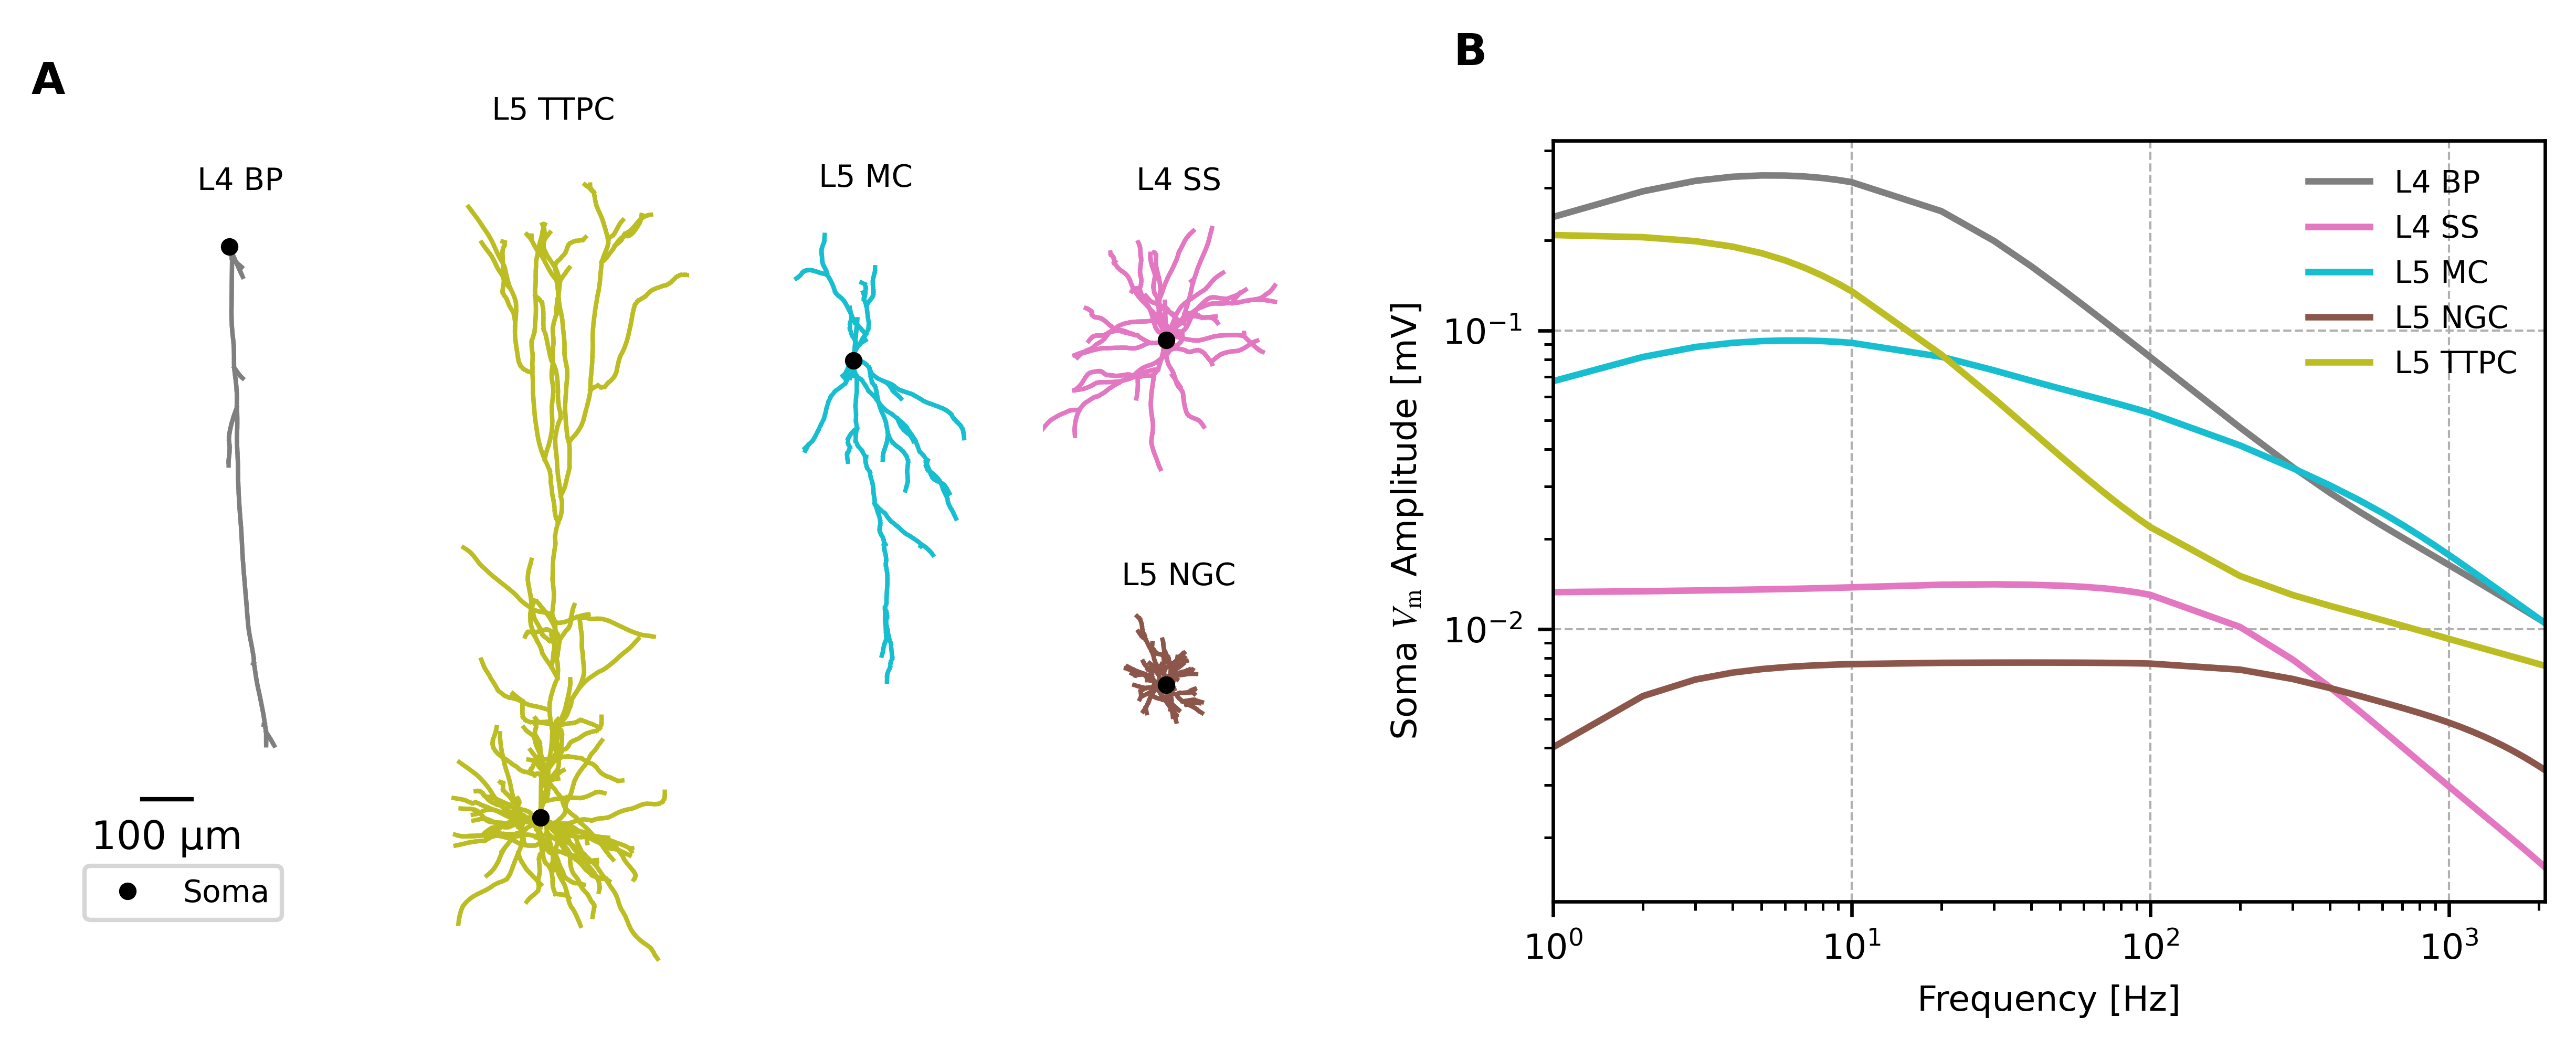

In [ ]:
plot_morph_and_amp(morph_plot_file_paths, vmem_amp_data, 'soma_amp', selected_cells)

In [ ]:
avg_amp_data_celltype = []

def calculate_avg_soma_amplitude(amp_data):
    """ Categorizes cells based on their names and calculates the average and standard deviation of soma amplitudes for each frequency within each category. """
    global avg_amp_data_celltype

    avg_amp_data_celltype = []

    # Dictionary to store categorized data
    categorized_data = {}

    # Loop through each cell and organize data by category
    for cell_name, data in amp_data.items():
        # Determine the category of the cell
        if 'PC' in cell_name or 'SP' in cell_name:
            cell_category = 'Pyramidal cells'
        elif 'SS' in cell_name:
            cell_category = 'Spiny Stellate cells'
        else: cell_category = 'Inhibitory neurons'
            
        
        # Initialize category in dictionary if not present
        if cell_category not in categorized_data:
            categorized_data[cell_category] = {}
        
        # Organize soma amplitudes by frequency
        for freq, soma_amp in zip(data['freq'], data['soma_amp']):
            if freq not in categorized_data[cell_category]:
                categorized_data[cell_category][freq] = []
            categorized_data[cell_category][freq].append(soma_amp)
    
    # Compute averages and standard deviations
    for category, freq_data in categorized_data.items():
        category_result = {
            'cell_category': category,
            'frequencies': [],
            'soma_amplitude': [],
            'std': []
        }
        
        for freq, amplitudes in sorted(freq_data.items()):
            category_result['frequencies'].append(freq)
            category_result['soma_amplitude'].append(np.mean(amplitudes))
            category_result['std'].append(np.std(amplitudes))
        

        avg_amp_data_celltype.append(category_result)
    

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def plot_combined_figure(morph_plot_file_paths, amp_data, amp_type, selected_cells, avg_amp_data_celltype):
    """
    Combines the morphology + amplitude spectra figure (fig1) above
    the soma combined figure (fig2) vertically.
    """

    # --- Create a single figure with vertical GridSpec ---
    fig = plt.figure(figsize=(8, 6))  # taller figure for stacking
    gs = fig.add_gridspec(3, 8, height_ratios=[4, 0.05, 3], hspace=0.1, wspace=2.7)
    
    # ------------------- Morphologies + Amp spectra -------------------
    gs_morph = gs[0, :4].subgridspec(2, 4, wspace=0.15, hspace=0.05)
    
    ax0 = fig.add_subplot(gs_morph[:, 0])
    ax1 = fig.add_subplot(gs_morph[:, 1])
    ax2 = fig.add_subplot(gs_morph[:, 2])
    ax3 = fig.add_subplot(gs_morph[0, 3])
    ax4 = fig.add_subplot(gs_morph[1, 3])
    axs_dict = {'ax0': ax0, 'ax1': ax1, 'ax2': ax2, 'ax3': ax3, 'ax4': ax4}

    # Load morphology data
    morph_dict = load_plot_data_from_files(morph_plot_file_paths, selected_cells)
    cell_to_axis = {
        'L4_BP_bIR215_5': 'ax0',
        'L5_TTPC2_cADpyr232_3': 'ax1',
        'L5_MC_bAC217_1': 'ax2',
        'L4_SS_cADpyr230_1': 'ax3',
        'L5_NGC_bNAC219_5': 'ax4'
    }

    all_x, all_z = [], []

    # Plot morphologies
    for label, ax_key in cell_to_axis.items():
        ax = axs_dict[ax_key]
        cell_data = morph_dict[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        color = cell_vmem_colors[label]

        for idx in range(totnsegs):
            ax.plot(x[idx], z[idx], c=color, lw=1)
        ax.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='black', markersize=3, label='Soma')

        all_x.extend(x.flatten())
        all_z.extend(z.flatten())

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f'{short_cell_names[label]}', fontsize=7)

    all_x = np.array(all_x)
    x_min, x_max = np.min(all_x), np.max(all_x)
    for ax in axs_dict.values():
        ax.set_xlim(x_min, x_max)

    # Vertical offsets
    # move_offsets = {'ax0':0, 'ax1':-1.44, 'ax2':0.05, 'ax3':-0.06, 'ax4':0.75} #positive = move up, negative = move down
    # for ax_key, offset in move_offsets.items():
    #     ax = axs_dict[ax_key]
    #     pos = ax.get_position()
    #     ax.set_position([pos.x0, pos.y0 + offset, pos.width, pos.height])

    # Shared scale bar
    scale_bar_length = 100
    ax_xlim = ax2.get_xlim()
    ax_ylim = ax2.get_ylim()
    scale_bar_x_start = ax_xlim[0] + 0.30 * (ax_xlim[1] - ax_xlim[0])
    scale_bar_x_end = scale_bar_x_start + scale_bar_length
    scale_bar_y = ax_ylim[0] - 0.2 * np.ptp(ax_ylim)
    ax2.plot([scale_bar_x_start, scale_bar_x_end], [scale_bar_y, scale_bar_y], color='k', lw=1)
    ax2.text((scale_bar_x_start + scale_bar_x_end)/2, scale_bar_y - 40,
             f'{scale_bar_length} µm', fontsize=9, va='top', ha='center')

    # Single Soma legend
    dot_handle = Line2D([], [], color='black', marker='o', linestyle='None', markersize=3, label='Soma')
    fig.legend(handles=[dot_handle], loc='center', bbox_to_anchor=(0.15, 0.52), fontsize=7, frameon=True)

    ax0.text(-0.65, 1.2, 'A', transform=ax0.transAxes, fontsize=12, fontweight='bold')

    # Amplitude spectra subplot
    axB = fig.add_subplot(gs[0, 5:8])
    for cell_name, data in amp_data.items():
        if cell_name in selected_cells:
            if amp_type == 'soma_amp':
                freqs = data['freq']
                ylab = 'Soma $V_\\mathrm{m}$ Amplitude [mV]'
                color = cell_vmem_colors[cell_name]
            elif amp_type == 'cdm':
                freqs = data['frequency']
                ylab = "Dipole Moment Amplitude [A·m]"
                color = cell_cdm_colors[cell_name]
            else:
                raise ValueError('Unknown amp type')
            amps = data[amp_type]
            axB.loglog(freqs, amps, label=f'{short_cell_names[cell_name]}', color=color)
    axB.set_xlabel('Frequency [Hz]')
    axB.set_xlim(left=freqs[0], right=freqs[-1])
    axB.set_ylabel(ylab)
    axB.grid(linestyle='--', linewidth=0.5)
    axB.legend(loc='upper right', fontsize=5, frameon=False)
    axB.text(-0.15, 1.15, 'B', transform=axB.transAxes, fontsize=12, fontweight='bold')
    axB.set_aspect('equal', adjustable='box')

    # ------------------- Soma amplitude plots -------------------
    axC = fig.add_subplot(gs[2, 0:4])
    axD = fig.add_subplot(gs[2, 4:8])
    fig.subplots_adjust(hspace=0.5)

    # Subplot C: individual neurons
    for cell_name, data in amp_data.items():
        if cell_name in selected_cells: 
            continue
        freqs = data['freq']
        amps = data['soma_amp']
        if 'PC' in cell_name or 'SP' in cell_name:
            color, alpha, lw = 'tab:green', 0.6, 0.5
        elif 'SS' in cell_name:
            color, alpha, lw = 'tab:purple', 1, 0.6
        else:
            color, alpha, lw = 'tab:orange', 0.15, 0.5
        axC.loglog(freqs, amps, color=color, alpha=alpha, lw=lw)
    for cell_name in selected_cells:
        freqs = amp_data[cell_name]['freq']
        amps = amp_data[cell_name]['soma_amp']
        axC.loglog(freqs, amps, color='black', lw=1.6, alpha=1)
        axC.loglog(freqs, amps, color=cell_vmem_colors[cell_name], lw=1.3, alpha=1)
    axC.set_xlabel('Frequency [Hz]', fontsize=8)
    axC.set_ylabel('Soma $V_\mathrm{m}$ Amplitude [mV]', fontsize=8)
    axC.set_title('Individual neocortical neurons', fontsize=10)
    axC.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
    axC.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.6)
    axC.set_xlim(left=freqs[0], right=freqs[-1])
    custom_legend = [
        Line2D([0], [0], color='tab:green', lw=0.6, label='Pyramidal cells'),
        Line2D([0], [0], color='tab:purple', lw=0.6, label='Spiny Stellate cells'),
        Line2D([0], [0], color='tab:orange', lw=0.6, label='Inhibitory neurons'),
    ]
    axC.legend(handles=custom_legend, loc='lower left', fontsize=7, ncol=1)
    axC.text(-0.15, 1.05, 'C', transform=axC.transAxes, fontsize=12, fontweight='bold')

    # Subplot D: averages
    for cell_data in avg_amp_data_celltype:
        freqs = np.array(cell_data['frequencies'])
        avg = np.array(cell_data['soma_amplitude'])
        std = np.array(cell_data['std'])
        upper, lower = avg + std, avg - std
        if cell_data['cell_category'] == 'Pyramidal cells':
            color = 'tab:green'
        elif cell_data['cell_category'] == 'Spiny Stellate cells':
            color = 'tab:purple'
        else:
            color = 'tab:orange'
        axD.loglog(freqs, avg, linestyle='--', lw=1, label=f"{cell_data['cell_category']} avg",
                   color=color, marker='.', markersize=4)
        axD.fill_between(freqs, lower, upper, color=color, alpha=0.2)
    axD.set_xlabel('Frequency [Hz]', fontsize=8)
    axD.set_ylabel('Soma $V_\mathrm{m}$ Amplitude [mV]', fontsize=8)
    axD.set_title('Cell-type averages', fontsize=10)
    axD.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
    axD.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.6)
    axD.set_xlim(left=freqs[0], right=freqs[-1])
    axD.legend(fontsize=7, loc='lower left')
    axD.text(-0.10, 1.05, 'D', transform=axD.transAxes, fontsize=12, fontweight='bold')

    plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/neocortical/fig1.pdf', bbox_inches="tight")
    plt.show()


<>:136: SyntaxWarning: invalid escape sequence '\m'
<>:165: SyntaxWarning: invalid escape sequence '\m'
<>:136: SyntaxWarning: invalid escape sequence '\m'
<>:165: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_40419/419328374.py:136: SyntaxWarning: invalid escape sequence '\m'
  axC.set_ylabel('Soma $V_\mathrm{m}$ Amplitude [mV]', fontsize=8)
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_40419/419328374.py:165: SyntaxWarning: invalid escape sequence '\m'
  axD.set_ylabel('Soma $V_\mathrm{m}$ Amplitude [mV]', fontsize=8)


In [50]:
calculate_avg_soma_amplitude(vmem_amp_data)

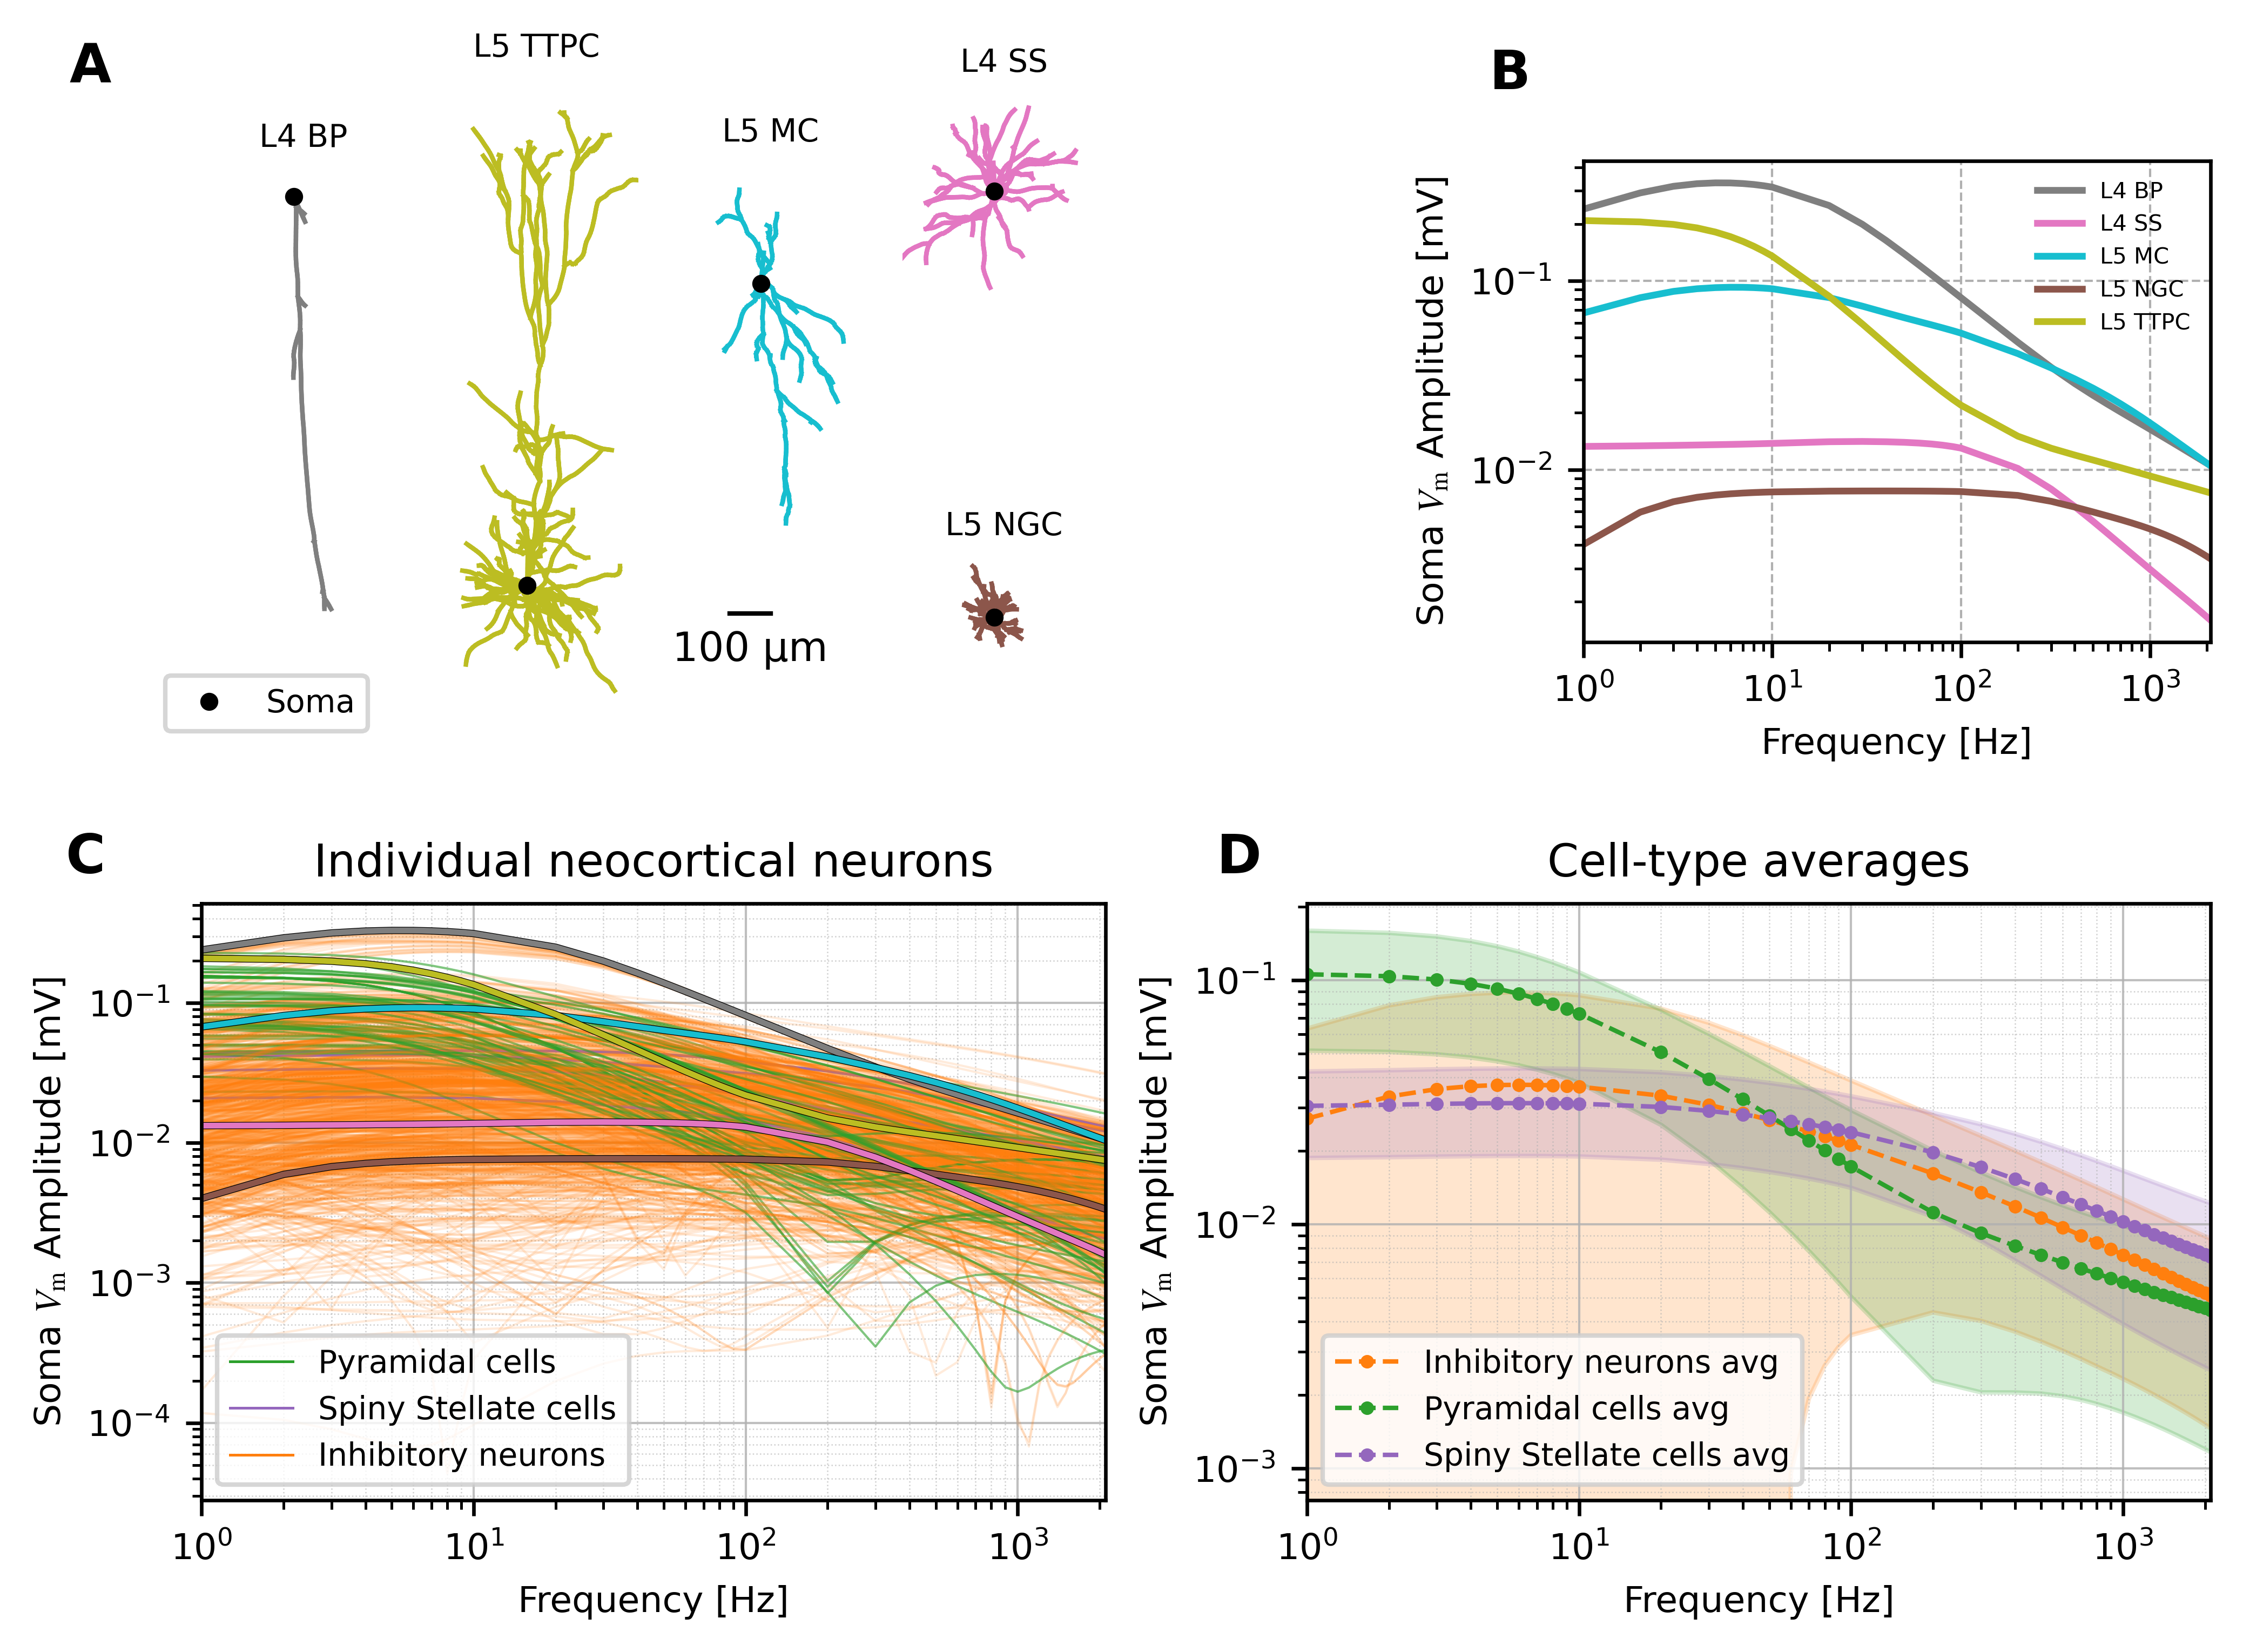

In [51]:
plot_combined_figure(morph_plot_file_paths, vmem_amp_data, 'soma_amp', selected_cells, avg_amp_data_celltype)